In [215]:
import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm.auto import tqdm

In [216]:
def random_solution(data,i:int):
    path = []
    value = 0
    limit = len(data) // 2
    cur, cost = data[i][:-1], data[i][-1]
    while(len(data) > limit):
        path.append(np.append(cur, cost))
        data = np.delete(data, i, 0)
        i = random.randint(0, len(data)-1)
        value += round(np.linalg.norm(cur-data[i][:-1])) + data[i][-1]
        cur, cost = data[i][:-1], data[i][-1]
        
    value += round(np.linalg.norm(path[0][:-1]-cur)) + path[0][-1]
    path.append(path[0])
    return value, path

In [217]:
def nearest_neighbor(data,i: int):
    path = []
    value = 0
    limit = len(data) // 2
    cur, cost = data[i][:-1], data[i][-1]
    while(len(data) > limit):
        path.append(np.append(cur, cost))
        data = np.delete(data, i, 0)
        costs = np.apply_along_axis(lambda node: round(np.linalg.norm(cur-node[:-1])) + node[-1], 1, data)
        i = np.argmin(costs)
        value += costs[i]
        cur, cost = data[i][:-1], data[i][-1]
        
    value += round(np.linalg.norm(path[0][:-1]-cur)) + path[0][-1]
    path.append(path[0])
    return value, path

In [218]:
from scipy.spatial.distance import cdist

In [219]:
def calculate_average(*args,**kwargs):
    return np.mean(args)

In [220]:
def calculate_cost(data: np.ndarray) -> np.ndarray:
    costs = cdist(data[:,2].reshape(-1,1), data[:,2].reshape(-1,1),calculate_average)
    distances = np.round(cdist(data[:,:2], data[:,:2], 'euclidean'))
    distances = distances + costs
    return distances

In [221]:
def greedy_cycle(data,node_index:int):
    distances = calculate_cost(data)
    visited,edges = [],[]
    limit = len(data) // 2
    # node_index = random.randint(0, len(data)-1)
    cost = data[node_index][-1]
    value = cost
    edges.append([node_index,node_index])
    visited.append(node_index)
    while(len(visited) < limit):
        costs = []
        for edge in edges:
            temp = distances[edge].sum(axis=0)
            temp[visited] = np.inf
            temp-=distances[edge[0],edge[1]]
            costs.append([temp.min() ,temp.argmin()])
        costs = np.array(costs)
        best_new_node_index = costs[:,0].argmin()
        cost,new_node_index = costs[best_new_node_index]
        value+=cost
        visited.append(int(new_node_index))
        parent_nodes = edges.pop(best_new_node_index)
        edges += [[parent_nodes[0],int(new_node_index)],[parent_nodes[1],int(new_node_index)]]
    edges = sort_edges(edges=edges)
    path = data[np.array(edges).flatten()]
    return value, path

In [222]:
def get_match_node(edge1: list, edge2: list) -> list:
    intersection = set(edge1).intersection(set( edge2))
    return list(intersection)

In [223]:
def sort_edges(edges: list) -> list:
    edges_sorted = [edges.pop(0)]
    last_edge = edges_sorted[-1]
    number_of_edges = len(edges)
    while len(edges_sorted) != number_of_edges:
        index = 0
        while len(edges) > index:
            matching_node = get_match_node(last_edge, edges[index])
            if matching_node:
                matching_node = matching_node[0]
                last_edge = last_edge if matching_node == last_edge[1] else last_edge[::-1]
                edge = edges.pop(index)
                edge = edge if last_edge[1] == edge[0] else edge[::-1]
                edges_sorted[-1] = last_edge
                edges_sorted.append(edge)
                last_edge = edges_sorted[-1]
                break
            index+=1
    edges_sorted.append(edges.pop(0))
    return edges_sorted

In [224]:
data = np.loadtxt('TSPA.csv', dtype=int, delimiter=';')

In [225]:
def evaluate(func, data, n=200):
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    for node_index in tqdm(range(n)):
        value, solution = func(data,node_index)
        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)
    return total / n, worst_value, best_value, np.array(best_solution).T

In [226]:
def summarize(func, data, title):
    average, worst_value, best_value, (x, y, z) = evaluate(func, data)
    print(f'{title}:')
    print(f'average score: {average}\tworst score: {worst_value}\tbest score: {best_value}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(x, y, np.full(x.size, 100), z, cmap='gray_r')
    plt.clim(0, 2000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()

In [227]:
data = np.loadtxt('TSPA.csv', dtype=int, delimiter=';')

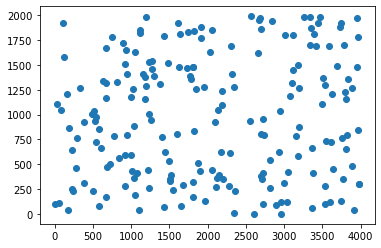

In [228]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Random solution:
average score: 266872.145	worst score: 291554	best score: 238641
Best solution:


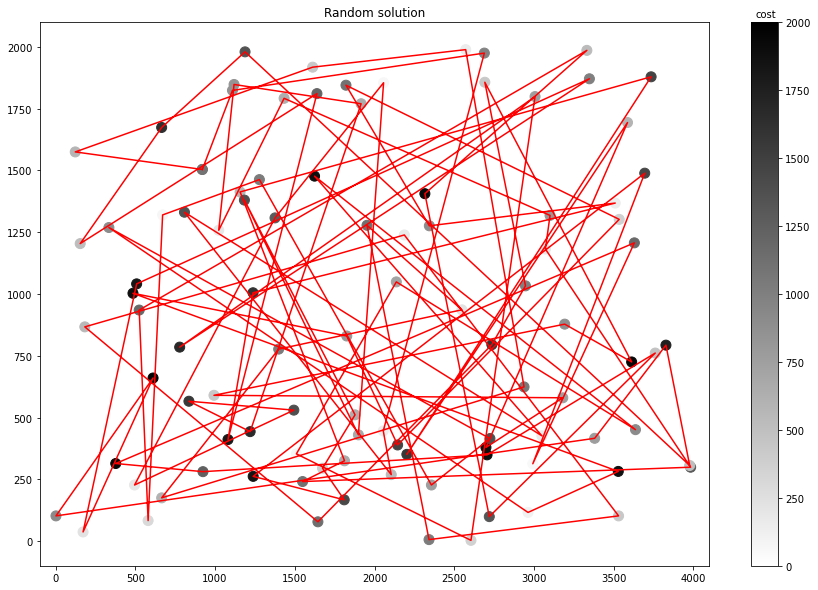

In [229]:
summarize(random_solution, data, 'Random solution')

  0%|          | 0/200 [00:00<?, ?it/s]

Nearest neighbor:
average score: 88949.92	worst score: 96922	best score: 85794
Best solution:


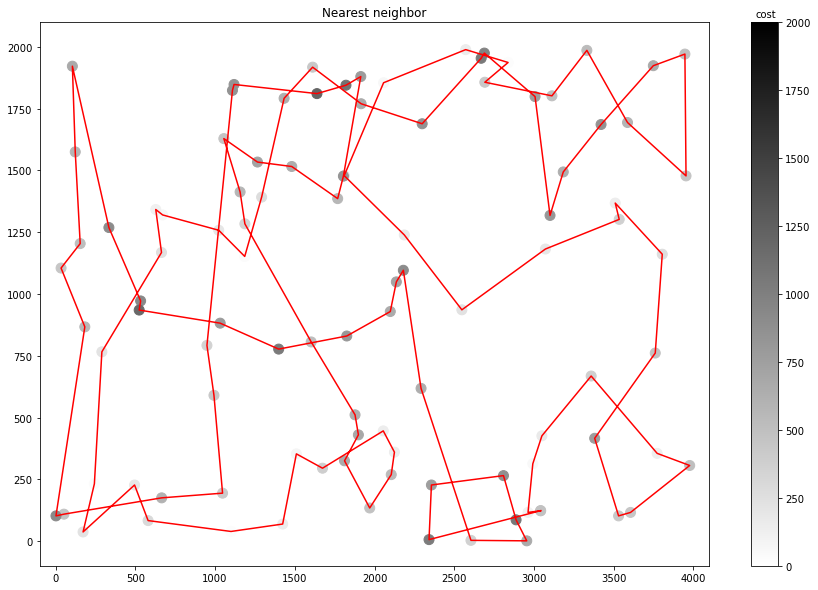

In [230]:
summarize(nearest_neighbor, data, 'Nearest neighbor')

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average score: 77046.45	worst score: 79891.0	best score: 75654.0
Best solution:


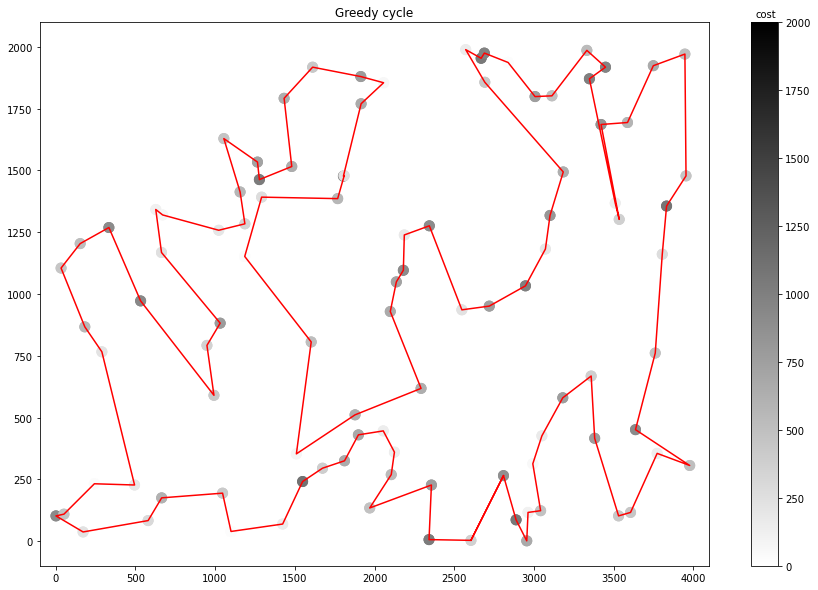

In [231]:
summarize(greedy_cycle, data, 'Greedy cycle')

In [232]:
data = np.loadtxt('TSPB.csv', dtype=int, delimiter=';')

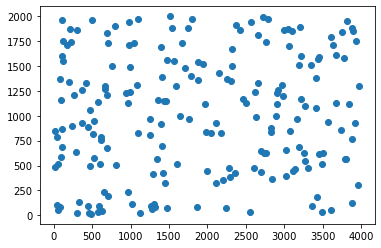

In [233]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Random solution:
average score: 269807.27	worst score: 294155	best score: 248391
Best solution:


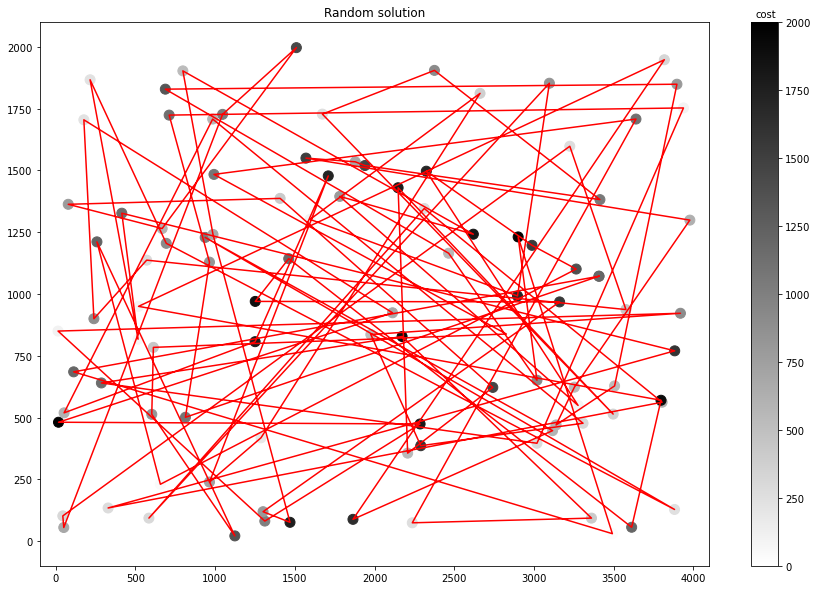

In [234]:
summarize(random_solution, data, 'Random solution')

  0%|          | 0/200 [00:00<?, ?it/s]

Nearest neighbor:
average score: 80333.3	worst score: 83500	best score: 78548
Best solution:


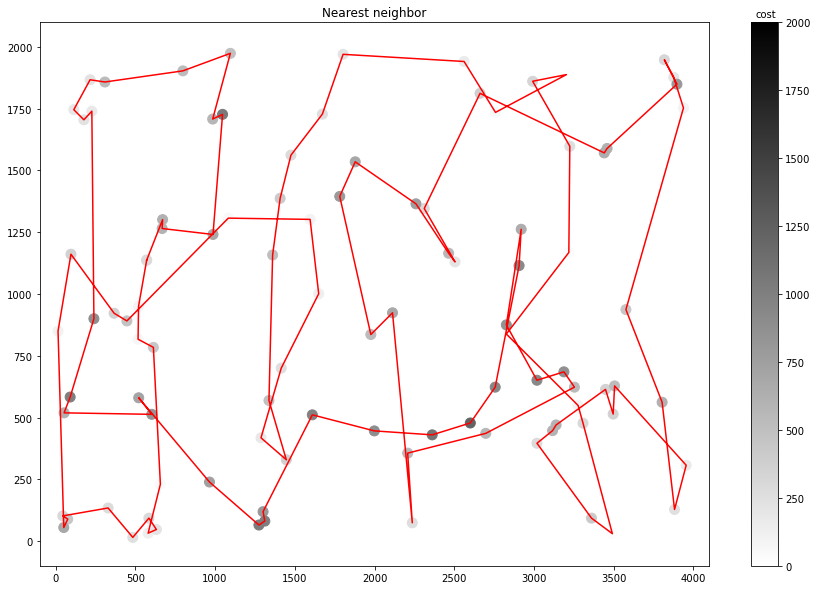

In [235]:
summarize(nearest_neighbor, data, 'Nearest neighbor')

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average score: 70734.49	worst score: 76324.0	best score: 68743.0
Best solution:


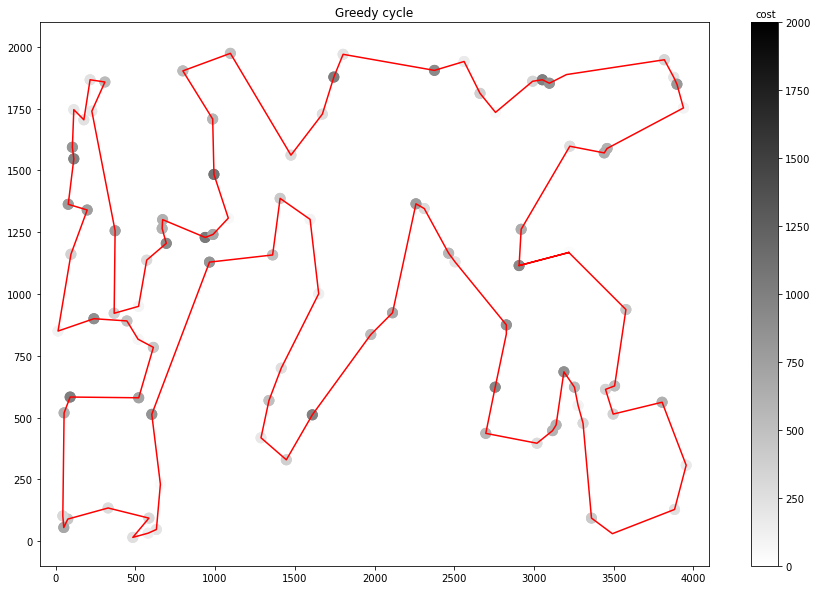

In [236]:
summarize(greedy_cycle, data, 'Greedy cycle')